In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
# Import Libs

from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#Sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

In [0]:
# Import dataset
data_path = '/content/gdrive/My Drive/colab/ml/LoadPrediction/data/'
# load the new file
dataset = pd.read_csv(data_path + 'household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset.head()

Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]

In [0]:
print(dataset.columns)
required_features = ['Global_active_power']
dataset = dataset[required_features]
dataset.head()

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'sub_metering_4'],
      dtype='object')


Global_active_power
datetime                       
2006-12-16             1209.176
2006-12-17             3390.460
2006-12-18             2203.826
2006-12-19             1666.194
2006-12-20             2225.748

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa866f3d390>],
      dtype=object)

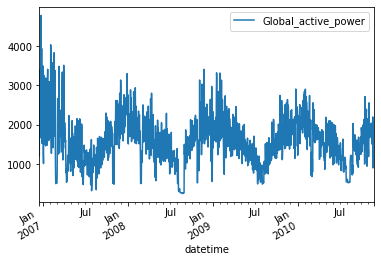

In [0]:
dataset.plot(subplots=True)

In [0]:
def split_data(data,train_percent):
  data = data.values
  print(data.shape)
  train_count = int(data.shape[0] * train_percent)
  train_data, test_data = np.split(data,[train_count])

  return train_data, test_data

In [0]:
train_percent = .8
train_data, test_data = split_data(dataset,train_percent)
print(train_data.shape)
print(test_data.shape)

(1442, 1)
(1153, 1)
(289, 1)


In [0]:
#Scaling
sc = MinMaxScaler()
train_data_trans = sc.fit_transform(train_data)
test_data_trans = sc.transform(test_data)
print(train_data[:5])
print(train_data_trans[:5])
print(test_data[:5])
print(test_data_trans[:5])

[[1209.176]
 [3390.46 ]
 [2203.826]
 [1666.194]
 [2225.748]]
[[0.21199632]
 [0.6942518 ]
 [0.43190139]
 [0.31303746]
 [0.43674808]]
[[1369.768]
 [1892.998]
 [2351.556]
 [1688.294]
 [2097.132]]
[[0.24750126]
 [0.36318108]
 [0.46456271]
 [0.31792351]
 [0.40831264]]


In [0]:
# start = Start index of array data to be used
# end = End index of array data to be used
# history_size = No. of datapoints to be used in previous window
# target_size = how far the data point in future e.g 0 for next
def prepare_data(data, start, end=None, history_size=1, target_size=0):
  inputs, targets = [], []
  # If start = 0, history = 7 i.e. look back 7 days
  # then window should begin from 0, and prediction data starts from 0+7 = 7
  start += history_size
  if end is None:
    # If no end given:
    # Train data should be (total data-points)-(data-points to be predicted)
    end = len(data) - target_size
  
  for i in range(start,end):
    # then window should begin from 0, and prediction data from 0+7 = 7
    indices = range(i-history_size, i)
    # Reshape data from 1D to 2D i.e. (history_size,) to (history_size,1)
    inputs.append(np.reshape(data[indices],(history_size,1)))
    targets.append(data[i+target_size])
  return np.array(inputs),np.array(targets)

In [0]:
past_history = 7
future_target = 0

x_train, y_train = prepare_data(train_data_trans,0,len(train_data_trans),past_history,future_target)
print(x_train.shape)
print(y_train.shape)

x_test, y_test = prepare_data(test_data_trans,0,len(test_data_trans),past_history,future_target)

print(x_test.shape)
print(y_test.shape)

(1146, 7, 1)
(1146, 1)
(282, 7, 1)
(282, 1)


In [0]:
print ('Single window of past history')
print (x_train[0],x_train[1])
print ('\n Target temperature to predict')
print (y_train[0])

Single window of past history
[[0.21199632]
 [0.6942518 ]
 [0.43190139]
 [0.31303746]
 [0.43674808]
 [0.32566026]
 [0.46230363]] [[0.6942518 ]
 [0.43190139]
 [0.31303746]
 [0.43674808]
 [0.32566026]
 [0.46230363]
 [1.        ]]

 Target temperature to predict
[1.]


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta=0, title='Graph'):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  # For X axis
  time_steps = create_time_steps(plot_data[0].shape[0])
  # delta!=0 when predicting some future point other than next step
  # No. of points after the last i/p at which prediction is to be done
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    print(i,x)
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

0 [[0.21199632]
 [0.6942518 ]
 [0.43190139]
 [0.31303746]
 [0.43674808]
 [0.32566026]
 [0.46230363]]
1 [1.]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

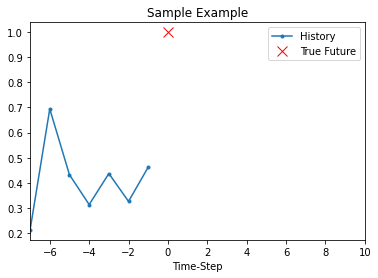

In [0]:
show_plot([x_train[0], y_train[0]], 0, 'Sample Example')

In [0]:
def baseline_model(history):
  return np.mean(history)

0 [[0.21199632]
 [0.6942518 ]
 [0.43190139]
 [0.31303746]
 [0.43674808]
 [0.32566026]
 [0.46230363]]
1 [1.]
2 0.41084270619667684


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

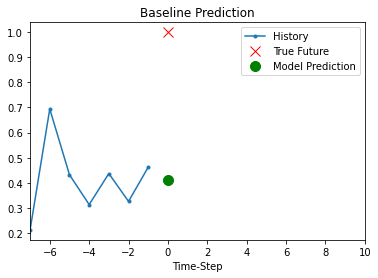

In [0]:
show_plot([x_train[0], y_train[0], baseline_model(x_train[0])],0,'Baseline Prediction')

In [0]:
# Build the model
def build_model(n_timesteps, n_features, n_outputs):
	model = Sequential()
	model.add(LSTM(8, input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	return model

In [0]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model = build_model(n_timesteps, n_features, n_outputs)

In [0]:
print(x_test.shape)
print(model.predict(x_test).shape)

(282, 7, 1)
(282, 1)


In [0]:
EPOCHS = 20
BATCH_SIZE = 16
model.summary()
# validation_data = (x_test,y_test)
history = model.fit(x_train,y_train,
          batch_size=BATCH_SIZE,
          epochs = EPOCHS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               900       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1146/1146 [==============================] - 1s 1ms/step - loss: 0.0272
Epoch 2/20
1146/1146 [==============================] - 1s 854us/step - loss: 0.0110
Epoch 3/20
1146/1146 [==============================] - 1s 850us/step - loss: 0.0106
Epoch 4/20
1146/1146 [==============================] - 1s 929us/step - loss: 0.0108
Epoch 5/20
1146/1146 [======================

0 [0.24750126 0.36318108 0.46456271 0.31792351 0.40831264 0.34212423
 0.39890049]
1 [0.33403241]
2 [0.3676403]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

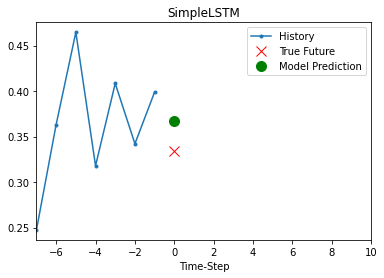

In [0]:
show_plot([x_test[0][:,0],y_test[0],model.predict(x_test)[0]],0, 'SimpleLSTM')

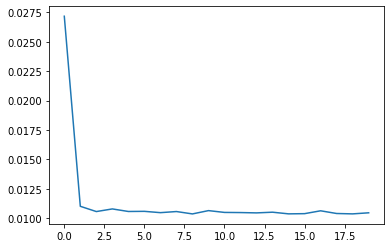

In [0]:
plt.plot(history.history['loss'])